Setup (fitting the model requires data transformers)

In [1]:
import time
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from pyreal.transformers import Transformer, OneHotEncoder, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from pyreal.transformers import fit_transformers

data_orig = pd.read_csv("trinket_data.csv", index_col=0)
y_orig = data_orig["price"]
X_orig = data_orig.drop("price", axis=1)


def hex_to_color_name(h):
    h = h.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return ["red", "green", "blue"][rgb.index(max(rgb))]


class ColorTransformer(Transformer):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        super().__init__(**kwargs)

    def fit(self, x):
        return self

    def data_transform(self, x):
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x


class MaxAggregator(Transformer):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        super().__init__(**kwargs)

    def data_transform(self, x):
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x

colorTransformer = ColorTransformer(columns=["color"])
colorEncoder = OneHotEncoder(columns=["color"])
maxAggregator = MaxAggregator(columns=["width", "height"])
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar',
                                          'color_blue', 'color_green', 'color_red',
                                          'MAX(width,height)'])

model_transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect]
X_model = fit_transformers(model_transformers, X_orig)

model = LinearRegression()
model.fit(X_model[0:400], y_orig[0:400])
print("Model r-squared: %.4f" % model.score(X_model[401:], y_orig[401:]))


Model r-squared: 0.9998


Simple Counterfactual Contribution - with Pyreal

          age  MAX(width,height)       type       color
0   16.950922         348.482259   5.344445  116.733621
1   19.353415         512.291606   5.979943  116.733621
2   27.895612         370.186290   5.344445   83.372331
3   20.955077         498.917952  15.885553   70.056164
4   16.363646         359.632196   5.979943   83.372331
..        ...                ...        ...         ...
95  31.899767         621.719775   5.979943  116.733621
96  19.620359         389.690002  15.885553   83.372331
97  24.532122         483.919060   5.979943  116.733621
98  16.897534         659.306325   5.344445   70.056164
99  24.478734         338.339398   5.344445   70.056164

[100 rows x 4 columns]
runtime: 0.3953368663787842


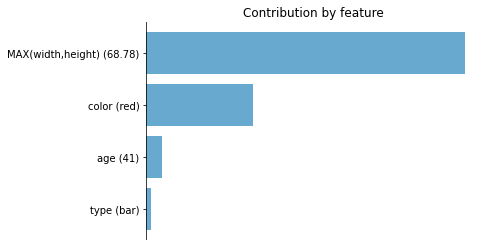

In [12]:
from pyreal.utils import visualize
from pyreal.transformers import Transformer, OneHotEncoder, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from pyreal.transformers import fit_transformers
from pyreal.explainers import SimpleCounterfactualContribution

start = time.time()


class ColorTransformer(Transformer):  # ****
    def __init__(self, columns, **kwargs):  # ****
        self.columns = columns
        super().__init__(**kwargs)

    def fit(self, x):  # ****
        return self  # ****

    def data_transform(self, x):  # ****
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x  # ****


class MaxAggregator(Transformer):  # ****
    def __init__(self, columns, **kwargs):  # ****
        self.columns = columns
        super().__init__(**kwargs)

    def data_transform(self, x):  # ****
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x  # ****


colorTransformer = ColorTransformer(columns=["color"], interpret=True)
colorEncoder = OneHotEncoder(columns=["color"])
maxAggregator = MaxAggregator(columns=["width", "height"], algorithm=True, interpret=True)
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar',
                                          'color_blue', 'color_green', 'color_red',
                                          'MAX(width,height)'])
mappings = Mappings.generate_mappings(
    categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings, algorithm=True, interpret=True)
typeEncoder = OneHotEncoder(columns=["type"])
model_transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect, typeDecoder, typeEncoder]
fit_transformers(model_transformers, X_orig)

explainer = SimpleCounterfactualContribution(model, X_orig, transformers=model_transformers, fit_on_init=True)
explanation_pyreal, X_interpret = explainer.produce(X_orig.iloc[:100])
print(explanation_pyreal)
print("runtime:", time.time()-start)

visualize.plot_top_contributors(explanation_pyreal, select_by="absolute",
                                values=X_interpret.iloc[0], show=True)


Simple Counterfactual Contribution - no Pyreal

runtime: 0.5665240287780762
        color        age        type  MAX(width,height)
0   22.469745  18.659362   70.037992          29.169000
1   22.469745  18.819528   83.386869          35.523340
2   13.255171  27.201559   70.037992          29.052963
3   17.250021  22.183018  116.682738          34.649724
4   13.255171  18.232252   83.386869          36.367732
..        ...        ...         ...                ...
95  22.469745  30.778604   83.386869          44.517867
96  13.255171  19.086472  116.682738          43.268438
97  22.469745  25.973618   83.386869          33.738499
98  17.250021  17.378032   70.037992          84.084728
99  17.250021  23.624514   70.037992          29.508487

[100 rows x 4 columns]


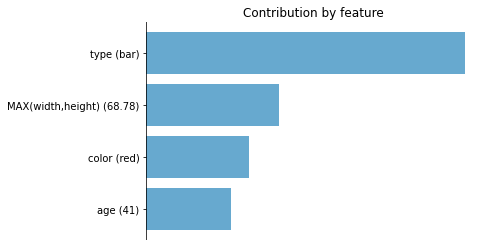

In [13]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import shap


n_iterations = 30
start = time.time()
def color_transform(x):  # ****
    _x = x.copy() # ****
    _x["color"] = _x["color"].apply(hex_to_color_name)
    return _x  # ****
def max_aggregate(x, columns):  # ****
    _x = x.copy() #****
    column_name = "MAX("
    column_name += ",".join(columns)
    column_name += ")"
    _x[column_name] = _x[columns].max(axis=1)
    _x = _x.drop(columns, axis=1)
    return _x  # ****
def type_decode(x): #****
    mappings_oh2c = {"type_foo": ("type", "foo"), "type_bar": (
        "type", "bar"), "type_foobar": ("type", "foobar")}
    cat_data = {}
    cols = x.columns
    num_rows = x.shape[0]
    for col in cols:
        if col not in mappings_oh2c:
            cat_data[col] = x[col]
        else:
            new_name = mappings_oh2c[col][0]
            if new_name not in cat_data:
                cat_data[new_name] = np.empty(num_rows, dtype="object")
            cat_data[new_name][np.where(x[col] == 1)] = mappings_oh2c[col][1]
    return pd.DataFrame(cat_data) #****
def alg_to_model(x): #****
    x = color_transform(x)
    to_encode = x[["color", "type"]]
    encoded_columns = ohe.get_feature_names(to_encode.columns)
    index = to_encode.index
    encoded = ohe.transform(to_encode)
    encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=index)
    x_2am = pd.concat([x.drop(["color", "type"], axis="columns"), encoded_df], axis=1)
    x_3am = x_2am[['age', 'type_bar', 'type_foo', 'type_foobar',
                   'color_blue', 'color_green', 'color_red', 'MAX(width,height)']]
    return x_3am #****
explain_x = X_orig.iloc[:100]
x_1a = max_aggregate(explain_x, columns=["width", "height"])
X_1a = max_aggregate(X_orig, columns=["width", "height"])
x_2a = type_decode(x_1a)
X_2a = type_decode(X_1a)
x_train_explain = X_2a #****
X_fit = color_transform(X_2a)
to_encode = X_fit[["color", "type"]]
ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
x_am = alg_to_model(x_2a)
pred_orig = model.predict(x_am)
contributions = pd.DataFrame(np.zeros_like(x_2a), columns=x_2a.columns)
for col in x_2a:
    total_abs_change = 0
    for i in range(n_iterations):
        x_copy = x_2a.copy()
        x_copy[col] = x_train_explain[col].sample().iloc[0]
        x_copy_am = alg_to_model(x_copy)
        pred_new = model.predict(x_copy_am)
        total_abs_change += abs(pred_new - pred_orig)
    contributions[col] = total_abs_change / n_iterations
explanation_df = contributions #****
X_1i = color_transform(X_orig)
X_2i = max_aggregate(X_1i, columns=["width", "height"])
X_3i = type_decode(X_2i)
print("runtime:", time.time()-start)
print(explanation_df)
visualize.plot_top_contributors(explanation_df, select_by="absolute",
                                values=X_3i.iloc[0], show=True)


Local Feature Contributions - Pyreal

In [4]:
from pyreal.transformers import Transformer, OneHotEncoder, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from pyreal.transformers import fit_transformers
from pyreal.explainers import LocalFeatureContribution

start = time.time()
class ColorTransformer(Transformer): #****
    def __init__(self, columns, **kwargs): #****
        self.columns = columns
        super().__init__(**kwargs)
    def fit(self, x): #****
        return self #****
    def data_transform(self, x): #****
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x #****
class MaxAggregator(Transformer): #****
    def __init__(self, columns, **kwargs): #****
        self.columns = columns
        super().__init__(**kwargs) 
    def data_transform(self, x): #****
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x #****
colorTransformer = ColorTransformer(columns=["color"], interpret=True)
colorEncoder = OneHotEncoder(columns=["color"])
maxAggregator = MaxAggregator(columns=["width", "height"], interpret=True)
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar',
                                          'color_blue', 'color_green', 'color_red',
                                          'MAX(width,height)'])
mappings = Mappings.generate_mappings(
    categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings, model=False, interpret=True)
model_transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect, typeDecoder]
fit_transformers(model_transformers, X_orig)

lfc = LocalFeatureContribution(model, X_orig, transformers=model_transformers, fit_on_init=True)
explanation_pyreal = lfc.produce(X_orig.iloc[:100])
print(explanation_pyreal)
print("runtime:", time.time()-start)


(          age  MAX(width,height)      color        type
0  -15.656246           8.279705 -20.622256   -8.060027
1    8.368684          39.201880 -20.622256   92.056552
2   23.584472          13.853105  -0.876739   -8.060027
3  -22.863724          37.544861  19.097510 -108.013055
4  -13.253753         -20.753272  -0.876739   92.056552
..        ...                ...        ...         ...
95  28.389458          50.433364 -20.622256   92.056552
96   9.169515         -32.254449  -0.876739 -108.013055
97 -27.668710          35.592235 -20.622256   92.056552
98  -2.842950         -78.169232  19.097510   -8.060027
99  17.978655           3.187405  19.097510   -8.060027

[100 rows x 4 columns],     color  age    type  MAX(width,height)
0     red   41     bar          68.784567
1     red   71  foobar          84.261218
2   green   90     bar          71.574072
3    blue   32     foo          83.431874
4   green   44  foobar          54.253466
..    ...  ...     ...                ...
95    re

Local feature contributions - no Pyreal

In [4]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import shap

start = time.time()
def color_transform(x, columns):  #****
    for col in columns:
        x[col] = x[col].apply(hex_to_color_name)
    return x #****
def max_aggregate(x, columns):  #****
    column_name = "MAX("
    column_name += ",".join(columns)
    column_name += ")"
    x[column_name] = x[columns].max(axis=1)
    x = x.drop(columns, axis=1)
    return x  #****
x_1 = max_aggregate(X_orig, columns=["width", "height"])
x_2 = color_transform(x_1, columns=["color"])
to_encode = x_2[["color"]]
color_ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = color_ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = color_ohe.transform(to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=index)
x_3 = pd.concat([x_2.drop(["color"], axis="columns"), encoded_df], axis=1)
x_explain = x_3[['age', 'type_bar', 'type_foo', 'type_foobar',
          'color_blue', 'color_green', 'color_red','MAX(width,height)']]
columns = x_explain.columns
explainer = shap.Explainer(model, x_explain)
explanation = explainer(x_explain.iloc[0:100])
explanation_df = pd.DataFrame(explanation.values, columns=columns)
for col in ["color", "type"]:
    encoded_features = [item for item in columns if item.startswith(col+'_')]
    summed_contribution = explanation_df[encoded_features].sum(axis=1)
    explanation_df = explanation_df.drop(encoded_features, axis="columns")
    explanation_df[col] = summed_contribution
print(explanation_df)
print("runtime:", time.time()-start)


          age  MAX(width,height)      color        type
0  -15.656246           8.279705 -20.622256   -8.060027
1    8.368684          39.201880 -20.622256   92.056552
2   23.584472          13.853105  -0.876739   -8.060027
3  -22.863724          37.544861  19.097510 -108.013055
4  -13.253753         -20.753272  -0.876739   92.056552
..        ...                ...        ...         ...
95  28.389458          50.433364 -20.622256   92.056552
96   9.169515         -32.254449  -0.876739 -108.013055
97 -27.668710          35.592235 -20.622256   92.056552
98  -2.842950         -78.169232  19.097510   -8.060027
99  17.978655           3.187405  19.097510   -8.060027

[100 rows x 4 columns]
runtime: 0.0632481575012207


Global feature importance - with Pyreal

In [5]:
from pyreal.transformers import Transformer, OneHotEncoder, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from pyreal.transformers import fit_transformers
from pyreal.explainers import GlobalFeatureImportance

start = time.time()
class ColorTransformer(Transformer):  # ****
    def __init__(self, columns, **kwargs):  # ****
        self.columns = columns
        super().__init__(**kwargs)
    def fit(self, x):  # ****
        return self  # ****
    def data_transform(self, x):  # ****
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x  # ****
class MaxAggregator(Transformer):  # ****
    def __init__(self, columns, **kwargs):  # ****
        self.columns = columns
        super().__init__(**kwargs)
    def data_transform(self, x):  # ****
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x  # ****
colorTransformer = ColorTransformer(columns=["color"], interpret=True)
colorEncoder = OneHotEncoder(columns=["color"])
maxAggregator = MaxAggregator(columns=["width", "height"], interpret=True)
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar',
                                          'color_blue', 'color_green', 'color_red',
                                          'MAX(width,height)'])
mappings = Mappings.generate_mappings(
    categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings, model=False, interpret=True)
model_transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect, typeDecoder]
fit_transformers(model_transformers, X_orig)
gfi = GlobalFeatureImportance(model, X_orig, transformers=model_transformers, fit_on_init=True)
explanation_pyreal = gfi.produce()
print(explanation_pyreal)
print("runtime:", time.time()-start)


         age  MAX(width,height)      color       type
0  15.962804          30.875724  18.201658  89.316062
runtime: 0.03803229331970215


Global feature importance - no Pyreal

In [6]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import shap

start = time.time()
def color_transform(x, columns):  # ****
    for col in columns:
        x[col] = x[col].apply(hex_to_color_name)
    return x  # ****
def max_aggregate(x, columns):  # ****
    column_name = "MAX("
    column_name += ",".join(columns)
    column_name += ")"
    x[column_name] = x[columns].max(axis=1)
    x = x.drop(columns, axis=1)
    return x  # ****
x_1 = max_aggregate(X_orig, columns=["width", "height"])
x_2 = color_transform(x_1, columns=["color"])
to_encode = x_2[["color"]]
color_ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = color_ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = color_ohe.transform(to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=index)
x_3 = pd.concat([x_2.drop(["color"], axis="columns"), encoded_df], axis=1)
x_explain = x_3[['age', 'type_bar', 'type_foo', 'type_foobar',
                 'color_blue', 'color_green', 'color_red', 'MAX(width,height)']]
columns = x_explain.columns
explainer = shap.Explainer(model, x_explain)
explanation = explainer(x_explain)
explanation = np.mean(np.absolute(explanation.values), axis=0).reshape(1, -1)
explanation_df = pd.DataFrame(explanation, columns=columns)
for col in ["color", "type"]:
    encoded_features = [item for item in columns if item.startswith(col+'_')]
    summed_contribution = explanation_df[encoded_features].sum(axis=1)
    explanation_df = explanation_df.drop(encoded_features, axis="columns")
    explanation_df[col] = summed_contribution
print(explanation_df)
print("runtime:", time.time()-start)


         age  MAX(width,height)      color       type
0  15.962804          30.875724  18.201658  89.316062
runtime: 0.037420034408569336


Decision Tree Explainer - with Pyreal

In [7]:
from pyreal.transformers import Transformer, OneHotEncoder, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from pyreal.transformers import fit_transformers
from pyreal.explainers import DecisionTreeExplainer

start = time.time()
class ColorTransformer(Transformer):  # ****
    def __init__(self, columns, **kwargs):  # ****
        self.columns = columns
        super().__init__(**kwargs)
    def fit(self, x):  # ****
        return self  # ****
    def data_transform(self, x):  # ****
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x  # ****
class MaxAggregator(Transformer):  # ****
    def __init__(self, columns, **kwargs):  # ****
        self.columns = columns
        super().__init__(**kwargs)
    def data_transform(self, x):  # ****
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x  # ****
colorTransformer = ColorTransformer(columns=["color"], interpret=True)
colorEncoder = OneHotEncoder(columns=["color"])
maxAggregator = MaxAggregator(columns=["width", "height"], interpret=True)
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar',
                                          'color_blue', 'color_green', 'color_red',
                                          'MAX(width,height)'])
mappings = Mappings.generate_mappings(
    categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings, model=False, interpret=True)
model_transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect, typeDecoder]
fit_transformers(model_transformers, X_orig)
dte = DecisionTreeExplainer(model, X_orig, is_classifier=False, max_depth=4, transformers=model_transformers, fit_on_init=True)
explanation_pyreal = dte.produce()
print("runtime:", time.time()-start)


runtime: 0.045400142669677734


Decision Tree Explainer - no Pyreal

In [8]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn import tree

start = time.time()
def color_transform(x, columns):  # ****
    for col in columns:
        x[col] = x[col].apply(hex_to_color_name)
    return x  # ****
def max_aggregate(x, columns):  # ****
    column_name = "MAX("
    column_name += ",".join(columns)
    column_name += ")"
    x[column_name] = x[columns].max(axis=1)
    x = x.drop(columns, axis=1)
    return x  # ****
x_1 = max_aggregate(X_orig, columns=["width", "height"])
x_2 = color_transform(x_1, columns=["color"])
to_encode = x_2[["color"]]
color_ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = color_ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = color_ohe.transform(to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=index)
x_3 = pd.concat([x_2.drop(["color"], axis="columns"), encoded_df], axis=1)
x_explain = x_3[['age', 'type_bar', 'type_foo', 'type_foobar',
                 'color_blue', 'color_green', 'color_red', 'MAX(width,height)']]
columns = x_explain.columns
sklearn_explanation = tree.DecisionTreeRegressor()
sklearn_explanation.fit(x_explain, model.predict(x_explain))
print("runtime:", time.time()-start)


runtime: 0.01192331314086914
